In [1]:
from google.colab import files
uploaded = files.upload()

Saving grip_dataset.zip to grip_dataset.zip


In [2]:
import zipfile

with zipfile.ZipFile("grip_dataset.zip", "r") as z:
    z.extractall(".")

In [4]:
import os, glob, json, cv2, torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

DATASET_DIR = "grip_dataset"

READY_JOINTS = torch.tensor([-52.00, 1.00, -69.00, 84.25, -13.50, 11.75], dtype=torch.float32)

class GripDataset(Dataset):
    def __init__(self, dir_path):
        self.img_paths = sorted(
            glob.glob(os.path.join(dir_path, "image_*.jpg"))
        )
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        # read image
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img = self.transform(img_rgb)

        # read joints from matching JSON
        json_path = img_path.replace("image_", "joints_").replace(".jpg", ".json")
        with open(json_path, "r") as f:
            data = json.load(f)

        joints = torch.tensor(data["joints"], dtype=torch.float32)

        # deltas = how far this pose is from ready_to_grab
        deltas = joints - READY_JOINTS

        return img, joints, deltas

dataset = GripDataset(DATASET_DIR)
print("Number of samples:", len(dataset))

Number of samples: 31


In [5]:
from torch.utils.data import random_split

# 80% training, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Train samples:", train_size)
print("Validation samples:", val_size)

Train samples: 24
Validation samples: 7


In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class GripNet(nn.Module):
    def __init__(self):
        super().__init__()
        # ResNet18 backbone
        self.backbone = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1
        )
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # New head: 512 (image features) + 6 (joints) -> 6 deltas
        self.fc = nn.Sequential(
            nn.Linear(in_feats + 6, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )

    def forward(self, img, joints):
        feats = self.backbone(img) # (batch, 512)
        x = torch.cat([feats, joints], 1) # (batch, 512+6)
        out = self.fc(x) # (batch, 6)
        return out

model = GripNet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


GripNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [7]:
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for imgs, joints, deltas in train_loader:
        imgs   = imgs.to(device)
        joints = joints.to(device)
        deltas = deltas.to(device)

        preds = model(imgs, joints)
        loss  = criterion(preds, deltas)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * imgs.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for imgs, joints, deltas in val_loader:
            imgs   = imgs.to(device)
            joints = joints.to(device)
            deltas = deltas.to(device)

            preds = model(imgs, joints)
            loss  = criterion(preds, deltas)
            running_val_loss += loss.item() * imgs.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset) if len(val_dataset) > 0 else 0.0
    val_losses.append(epoch_val_loss)

    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"- Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}"
    )

Epoch 1/20 - Train Loss: 177.2900, Val Loss: 139.2684
Epoch 2/20 - Train Loss: 130.0169, Val Loss: 126.8867
Epoch 3/20 - Train Loss: 97.6734, Val Loss: 124.8178
Epoch 4/20 - Train Loss: 76.6046, Val Loss: 57.4715
Epoch 5/20 - Train Loss: 60.7506, Val Loss: 37.8708
Epoch 6/20 - Train Loss: 43.4962, Val Loss: 29.9127
Epoch 7/20 - Train Loss: 26.7469, Val Loss: 123.3208
Epoch 8/20 - Train Loss: 17.2210, Val Loss: 316.1091
Epoch 9/20 - Train Loss: 14.1093, Val Loss: 243.5101
Epoch 10/20 - Train Loss: 17.6352, Val Loss: 108.7429
Epoch 11/20 - Train Loss: 21.6419, Val Loss: 81.3022
Epoch 12/20 - Train Loss: 13.2440, Val Loss: 18.8619
Epoch 13/20 - Train Loss: 24.0646, Val Loss: 14.1968
Epoch 14/20 - Train Loss: 10.2404, Val Loss: 29.1226
Epoch 15/20 - Train Loss: 6.6965, Val Loss: 39.0093
Epoch 16/20 - Train Loss: 16.7338, Val Loss: 21.7619
Epoch 17/20 - Train Loss: 9.5878, Val Loss: 18.2051
Epoch 18/20 - Train Loss: 18.9753, Val Loss: 13.4395
Epoch 19/20 - Train Loss: 19.7588, Val Loss: 13.

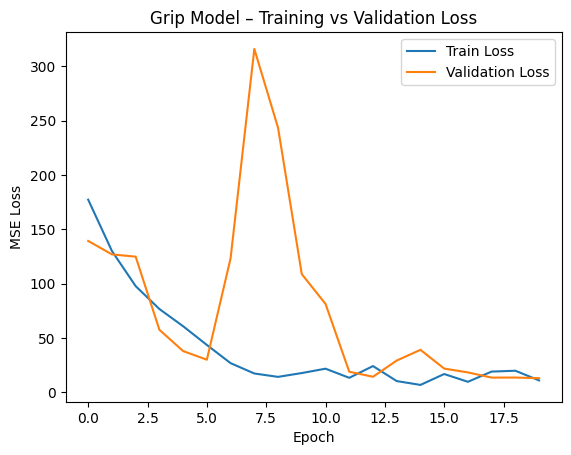

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Grip Model – Training vs Validation Loss")
plt.legend()
plt.show()

In [9]:
MODEL_PATH = "grip_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Saved model to", MODEL_PATH)

Saved model to grip_model.pth


In [10]:
from google.colab import files
files.download("grip_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
model = GripNet().to(device)
model.load_state_dict(torch.load("grip_model.pth"))
model.eval()

print("Model loaded and ready for inference.")


Model loaded and ready for inference.


In [13]:
test_img, test_joints, test_deltas = dataset[0]

test_img = test_img.unsqueeze(0).to(device)
test_joints = test_joints.unsqueeze(0).to(device)

with torch.no_grad():
    predicted_deltas = model(test_img, test_joints).cpu().numpy()

print("TEST SAMPLE RESULTS")
print("Original joints:", test_joints.cpu().numpy()[0])
print("True deltas:", test_deltas.numpy())
print("Predicted deltas:", predicted_deltas[0])

TEST SAMPLE RESULTS
Original joints: [-51.   1. -69.  84. -21.  11.]
True deltas: [ 1.    0.    0.   -0.25 -7.5  -0.75]
Predicted deltas: [-4.004037   4.818539   1.2851363 -1.6593721 -8.346596  -1.3376156]


In [14]:
import pandas as pd

df = pd.DataFrame({
    "Joint Index": [1, 2, 3, 4, 5, 6],
    "True Delta": test_deltas.numpy(),
    "Predicted Delta": predicted_deltas[0]
})

df

,Joint Index,True Delta,Predicted Delta
0,1,1.00,-4.004037
1,2,0.00,4.818539
2,3,0.00,1.285136
3,4,-0.25,-1.659372
4,5,-7.50,-8.346596
5,6,-0.75,-1.337616
